In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(handle="saadaliyaseen/shopping-behaviour-dataset")

print("Path to dataset files:", path)

100%|██████████| 70.5k/70.5k [00:00<00:00, 1.12MB/s]

Extracting files...
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/saadaliyaseen/shopping-behaviour-dataset/versions/1


In [19]:
os.listdir(path)[0]

'shopping_behavior_updated (1).csv'

In [20]:
import os
import pandas as pd

df = pd.read_csv(f"{path}/{os.listdir(path)[0]}")
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [29]:
import base64
import os
import requests
from langchain.tools import tool


# Reuse your existing config
AGENT_SANDBOX_API_URL = "http://python-sandbox-service:8888/execute"


def exec_command(command) -> str:    
    response = requests.post(
        AGENT_SANDBOX_API_URL,
        json={"command": command}, 
        timeout=120 # Larger files need more time
    )
    response.raise_for_status()
    
    result = response.json()
    stdout = result.get("stdout", "")
    stderr = result.get("stderr", "")

    if stderr:
        return f"Upload failed remotely:\n{stderr}"
    else:
        return f"Upload Complete. Sandbox Output: {stdout}"

loader_code = "curl -L -o /my-data/shopping-behaviour-dataset.zip  https://www.kaggle.com/api/v1/datasets/download/saadaliyaseen/shopping-behaviour-dataset"
unzip_code = "unzip /my-data/shopping-behaviour-dataset.zip -d /my-data"
mv_code = "mv '/my-data/shopping_behavior_updated (1).csv' /my-data/shopping_behavior_updated.csv"

print(exec_command(loader_code))
print(exec_command(unzip_code))
print(exec_command(mv_code))

Upload failed remotely:
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 72165  100 72165    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k

Upload Complete. Sandbox Output: Archive:  /my-data/shopping-behaviour-dataset.zip
  inflating: /my-data/shopping_behavior_updated (1).csv  

Upload Complete. Sandbox Output: 


--- Executing code ---

import pandas as pd
import matplotlib.pyplot as plt
import io
import base64

# Load the data
df = pd.read_csv('/my-data/shopping_behavior_updated.csv')

# Group by 'Location' and sum 'Purchase Amount (USD)'
purchase_amount_by_location = df.groupby('Location')['Purchase Amount (USD)'].sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
purchase_amount_by_location.plot(kind='bar')
plt.title('Total Purchase Amount (USD) by Location')
plt.xlabel('Location')
plt.ylabel('Total Purchase Amount (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save to buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img_str = base64.b64encode(buf.read()).decode('utf-8')
print(f"<IMG>{img_str}</IMG>")

----------------------


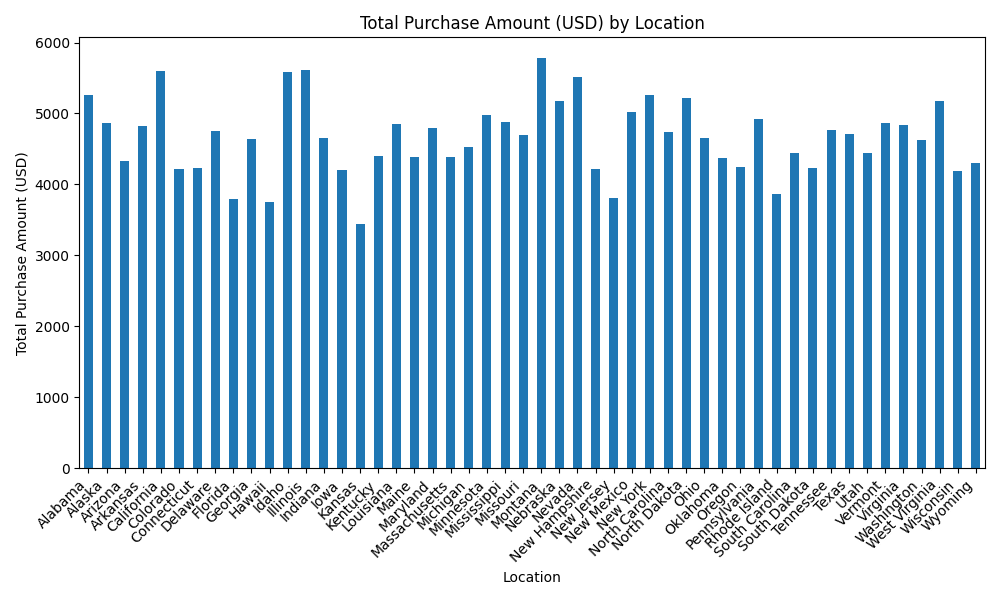

The bar chart shows the sum of 'Purchase Amount (USD)' per location.


In [33]:
import os
import requests
import base64
import re
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.tools import tool
from IPython.display import Image, display


os.environ["GOOGLE_API_KEY"] = ""
AGENT_SANDBOX_API_URL = "http://python-sandbox-service:8888/execute"


@tool
def analyze_movies(code: str) -> str:
    """
    Execute Python code for data analysis.

    IMPORTANT PLOTTING INSTRUCTIONS:
    If the user asks for a chart, graph, or plot, you MUST:
    1. Use matplotlib.pyplot.
    2. Instead of plt.show(), save the plot to a BytesIO buffer.
    3. Encode that buffer to base64.
    4. Print the base64 string wrapped in <IMG> tags.

    If you see message: "The image was rendered", then the user can see the image, and everything is fine.

    Example Python code to generate:
    ```python
    import matplotlib.pyplot as plt
    import io
    import base64

    # ... your plotting code ...
    plt.figure()
    plt.plot([1, 2, 3], [1, 4, 9])

    # Save to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    print(f"<IMG>{img_str}</IMG>")
    ```
    """
    print(f"--- Executing code ---\n{code}\n----------------------")

    try:
        encoded_code = base64.b64encode(code.encode('utf-8')).decode('utf-8')
        response = requests.post(
            AGENT_SANDBOX_API_URL,
            json={"command": f'python -c "import base64; exec(base64.b64decode(\'{encoded_code}\'))"'}, # Ensure your API accepts 'command' or 'code'
            timeout=60
        )
        response.raise_for_status()
        result_data = response.json()
        stdout = result_data.get("stdout", "")
        stderr = result_data.get("stderr", "")
    except Exception as e:
        return f"System Error: {e}"

    # --- IMAGE EXTRACTION LOGIC ---
    # regex to find content between <IMG> tags
    img_pattern = r"<IMG>(.*?)</IMG>"
    match = re.search(img_pattern, stdout, re.DOTALL)

    if match:
        img_data = match.group(1)
        try:
            # Decode base64
            image_bytes = base64.b64decode(img_data)

            # Render the image
            display(Image(data=image_bytes))

            # Remove the huge base64 string from stdout so we don't confuse the LLM
            stdout = re.sub(img_pattern, "The image was rendered", stdout)

            return f"Execution successful:\n:\n[stdout]: {stdout}\n[stderr]: {stderr}"
        except Exception as e:
            return f"Image detected but failed to save: {e}"

    if stderr:
        return f"Execution failed:\n[stderr]: {stderr}\n[stdout]: {stdout}"
    else:
        return f"Execution successful:\n[stdout]: {stdout}"

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

agent = create_agent(model, tools=[analyze_movies])

result = agent.invoke(
    {"messages": [{"role": "user", "content": "Load /my-data/shopping_behavior_updated.csv. This data has 'Purchase Amount (USD)' column. Create a bar chart showing a sum of 'Purchase Amount (USD)' per column 'Location'."}]}
)

print(result["messages"][-1].content)